In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [19]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

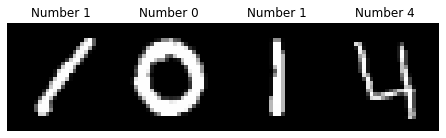

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=4)
for i in range(4):
    ax[i].set_title("Number {}".format(df.loc[i][0]))
    ax[i].imshow(np.array(df.loc[i][1:]).reshape(28,28),cmap='gray')
    ax[i].axis('off')
fig.tight_layout(pad=0.0)
plt.show()

# Baseline Model

In [ ]:
train, dev = train_test_split(df,test_size = 0.2, random_state = 42)

In [23]:
logreg = LogisticRegression(multi_class='multinomial')
logreg.fit(train.drop('label',axis=1),train.label)
logreg_pred = logreg.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,logreg_pred),4)))

Accuracy : 0.9183


In [24]:
cat = CatBoostClassifier(loss_function='MultiClass',n_estimators = 100,verbose = 0)
cat.fit(train.drop('label',axis=1),train.label, eval_set=(dev.drop('label',axis=1), dev.label))
cat_pred = cat.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,cat_pred),4)))

Accuracy : 0.9504


In [25]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(train.drop('label',axis=1),train.label)
knn_pred = knn.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,knn_pred),4)))

Accuracy : 0.9687


In [26]:
svc = SVC()
svc.fit(train.drop('label',axis=1),train.label)
svc_pred = svc.predict(dev.drop('label',axis=1))
print("Accuracy : {}".format(round(accuracy_score(dev.label,svc_pred),4)))

Accuracy : 0.9735


# Convolutional Neural Network

In [27]:
train_X = (np.array(train.drop('label',axis=1))/255).reshape(-1,28,28,1)
dev_X = (np.array(dev.drop('label',axis=1))/255).reshape(-1,28,28,1)
train_y = train.label.values.reshape(-1,1)
dev_y = dev.label.values.reshape(-1,1)

test = (np.array(test))/255.reshape(-1,28,28,1)

In [31]:
model = models.Sequential()
model.add(layers.RandomRotation(factor=0.05, fill_mode='constant'))  
model.add(layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2), fill_mode='constant'))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same',strides = 1, input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same',strides = 1))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(10,activation = 'softmax'))

In [37]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3
)

In [38]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
history = model.fit(train_X,train_y,
    validation_data=(dev_X,dev_y),
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    epochs=2000,
    verbose=1)

Epoch 1/2000
263/263 [==============================] - 44s 158ms/step - loss: 0.0343 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0283 - val_sparse_categorical_accuracy: 0.9910 - lr: 0.0010
Epoch 2/2000
263/263 [==============================] - 38s 146ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.0300 - val_sparse_categorical_accuracy: 0.9913 - lr: 0.0010
Epoch 3/2000
263/263 [==============================] - 38s 146ms/step - loss: 0.0354 - sparse_categorical_accuracy: 0.9894 - val_loss: 0.0293 - val_sparse_categorical_accuracy: 0.9901 - lr: 0.0010
Epoch 4/2000
263/263 [==============================] - 39s 147ms/step - loss: 0.0324 - sparse_categorical_accuracy: 0.9896 - val_loss: 0.0282 - val_sparse_categorical_accuracy: 0.9914 - lr: 0.0010
Epoch 5/2000
263/263 [==============================] - 39s 147ms/step - loss: 0.0241 - sparse_categorical_accuracy: 0.9925 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9933 - lr: 5.0000e-04
Epoch 

In [83]:
cnn_pred = np.argmax(model.predict(test),axis = 1)

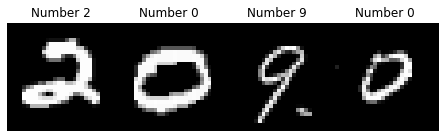

In [84]:
test_plot = pd.read_csv('test.csv')
fig, ax = plt.subplots(nrows=1, ncols=4)
for i in range(4):
    ax[i].set_title("Number {}".format(cnn_pred[i]))
    ax[i].imshow(np.array(test_plot.loc[i][:]).reshape(28,28),cmap='gray')
    ax[i].axis('off')
fig.tight_layout(pad=0.0)
plt.show()

In [94]:
submission=pd.DataFrame(zip(list(range(1,len(cnn_pred)+1)),cnn_pred),columns=['ImageId','Label'])
submission.to_csv('submission.csv',index = False)